In [196]:
# data munging
import pandas as pd
import numpy as np
import random

# visualization

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib import cm
from ipywidgets import interact
seq_col_brew = sns.color_palette("Blues_r", 4)
sns.set_palette(seq_col_brew)

In [197]:
all_user_data_df = pd.DataFrame.from_csv('generating_user_behavioral_data.csv')
all_user_data_df[['feature1', 'feature2', 'feature3']] = all_user_data_df[['feature1', 'feature2', 'feature3']].astype(int)
all_user_data_df.head()

,device_uuid,date,feature1,feature2,feature3,platform,user_registered,country
0,512ff3c3-fa27-442d-a116-126ec5e46d0b,2016-09-01,2,1,1,Android,False,AU
1,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2016-10-01,3,2,1,Android,False,AU
2,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2016-11-01,10,8,6,Android,False,AU
3,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2016-12-01,2,1,1,Android,False,AU
4,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2017-01-01,10,8,6,Android,False,AU


In [198]:
len(all_user_data_df['device_uuid'].unique())

9265

## Simulating difference in retention (iOS vs. Android)

In [199]:
# all the data is equally distributed across all features we want to remove a certain values to be able to visualize
# the difference in retention
# we want to simulate a 50% lower retention of iOS users compared to Android users

In [200]:
# extract only iOS users and check whether they have more than a month of usage data
ios_lt_df = pd.DataFrame(all_user_data_df[all_user_data_df['platform'] == 'iOS'].groupby('device_uuid').count()['date'] > 1).reset_index()
len(ios_lt_df)

6480

In [201]:
# extract the device_uuids from users that have more than a month of data
ios_lt_df= ios_lt_df[ios_lt_df['date'] == True]
ios_lt_df.reset_index(drop=True, inplace=True)
len(ios_lt_df)

2975

In [202]:
# assign 0 or 1 to all users that have more than a month of usage data
ios_lt_df['binary_split'] = pd.Series(np.random.randint(2, size=len(ios_lt_df)))

# extract only users that don't have the assigned values of 0 (50/50 split)
ios_lt_df = ios_lt_df[ios_lt_df['binary_split'] == 1.0]

# extract devices uuids into a list
ios_lt_devices = ios_lt_df['device_uuid']

len(ios_lt_devices)

1511

In [203]:
# removing the assigned devices
all_user_data_df_updated = all_user_data_df.query("device_uuid not in @ios_lt_devices")

In [204]:
len(all_user_data_df_updated['device_uuid'].unique())

7754

In [205]:
num_removed_devices = len(all_user_data_df['device_uuid'].unique()) -  len(all_user_data_df_updated['device_uuid'].unique())
len(ios_lt_devices) == num_removed_devices

True

In [206]:
all_user_data_df = all_user_data_df_updated.copy()

## 1. Segmenting users

In [207]:
def segmenting(df, country, platform, user_registered):

    # for each categorical (segmentation) feature
    if country != 'All countries':
        df = df[df['country'] == country]
        
    if platform != 'All platforms':
        df = df[df['platform'] == platform]
        
    if user_registered != 'True and False':
        df = df[df['user_registered'] == user_registered]
        
    return df

In [208]:
# NL / AU / FR
country_values = ['All countries'] + list(all_user_data_df['country'].unique())

# iOS / Android
platform_values = ['All platforms'] + list(all_user_data_df['platform'].unique())

# True / False
user_registered_values = ['True and False'] + list(all_user_data_df['user_registered'].unique())

In [209]:
country_value = 'NL'
platform_value = 'iOS'
user_registered_value = False

df = segmenting(all_user_data_df.copy(), country=country_value, platform=platform_value, user_registered=user_registered_value)
df.head()

,device_uuid,date,feature1,feature2,feature3,platform,user_registered,country
30,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-08-01,8,6,4,iOS,False,NL
31,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-09-01,3,2,1,iOS,False,NL
32,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-10-01,2,1,1,iOS,False,NL
33,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-11-01,9,7,5,iOS,False,NL
34,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-12-01,4,3,2,iOS,False,NL


## 2. Building cohorts

In [210]:
def preprocess_cohorting(df):
    df['sum'] = df['feature1'] + df['feature2'] + df['feature3']
    df['date'] = pd.to_datetime(df['date'])
    
    to_month = lambda x: x.strftime('%Y-%m')
    df['usage_period'] = df['date'].apply(to_month)
    
    df.set_index('device_uuid', inplace=True)
    df['cohort_group'] = df.groupby(level=0)['date'].min().apply(lambda x:  x.strftime('%Y-%m'))
    df.reset_index(inplace=True)
    
    return df

In [211]:
# step 1
df = preprocess_cohorting(df)
df.head()

,device_uuid,date,feature1,feature2,feature3,platform,user_registered,country,sum,usage_period,cohort_group
0,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-08-01,8,6,4,iOS,False,NL,18,2016-08,2016-08
1,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-09-01,3,2,1,iOS,False,NL,6,2016-09,2016-08
2,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-10-01,2,1,1,iOS,False,NL,4,2016-10,2016-08
3,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-11-01,9,7,5,iOS,False,NL,21,2016-11,2016-08
4,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-12-01,4,3,2,iOS,False,NL,9,2016-12,2016-08


In [212]:
def build_cohort_data(df):
    
    # group the df by cohort group and usage period
    grouped = df.groupby(['cohort_group', 'usage_period'])
    
    # aggregate the unique number of users and sum of all events
    cohorts = grouped.agg({'device_uuid': pd.Series.nunique,
                      'sum': np.sum})

    # rename the columns
    cohorts.rename(columns={'device_uuid': 'all_users',
                       'sum': 'all_num_events'}, inplace=True)
    return cohorts

In [213]:
# step 2
cohorts = build_cohort_data(df)
cohorts.head()

all_num_events  all_users
cohort_group usage_period                           
2016-02      2016-02                 3790        237
             2016-03                 1031         63
             2016-04                  879         59
             2016-05                  758         50
             2016-06                  879         48

In [214]:
def cohort_period(df):
    
    df['cohort_period'] = np.arange(len(df)) + 0
    return df

In [215]:
# step 3
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

all_num_events  all_users  cohort_period
cohort_group usage_period                                          
2016-02      2016-02                 3790        237              0
             2016-03                 1031         63              1
             2016-04                  879         59              2
             2016-05                  758         50              3
             2016-06                  879         48              4

In [216]:
def cohort_reindex_and_group_size(df):
    # reindex the dataframe
    df.reset_index(inplace=True)
    df.set_index(['cohort_group', 'cohort_period'], inplace=True)
    cohort_group_size = df['all_users'].groupby(level=0).first()
    return df, cohort_group_size

In [217]:
# step 4
cohorts, cohort_group_size = cohort_reindex_and_group_size(cohorts)
cohort_group_size

cohort_group
2016-02    237
2016-03    228
2016-04    223
2016-05    242
2016-06    210
2016-07    252
2016-08    211
2016-09    229
2016-10    226
Name: all_users, dtype: int64

In [218]:
cohorts

usage_period  all_num_events  all_users
cohort_group cohort_period                                        
2016-02      0                  2016-02            3790        237
             1                  2016-03            1031         63
             2                  2016-04             879         59
             3                  2016-05             758         50
             4                  2016-06             879         48
             5                  2016-07             718         46
             6                  2016-08             660         42
             7                  2016-09             627         42
             8                  2016-10             596         38
             9                  2016-11             516         37
             10                 2016-12             572         34
             11                 2017-01             420         27
             12                 2017-02             378         25
             13                 2017-03             407         24
             14                 2017-04             335         21
             15                 2017-05             299         16
             16                 2017-06             208         16
             17                 2017-07             221         16
             18                 2017-08             188         14
2016-03      0                  2016-03            3700        228
             1                  2016-04            1112         67
             2                  2016-05             890         62
             3                  2016-06             879         56
             4                  2016-07             886         52
             5                  2016-08             697         46
             6                  2016-09             708         41
             7                  2016-10             577         40
             8                  2016-11             594         37
             9                  2016-12             523         37
             10                 2017-01             542         36
...                                 ...             ...        ...
2016-08      6                  2017-02             667         43
             7                  2017-03             640         40
             8                  2017-04             719         39
             9                  2017-05             620         36
             10                 2017-06             524         34
             11                 2017-07             560         31
             12                 2017-08             430         26
2016-09      0                  2016-09            3539        229
             1                  2016-10            1189         70
             2                  2016-11             986         66
             3                  2016-12             995         62
             4                  2017-01             895         60
             5                  2017-02             930         57
             6                  2017-03             738         51
             7                  2017-04             693         50
             8                  2017-05             830         44
             9                  2017-06             758         41
             10                 2017-07             529         37
             11                 2017-08             552         35
2016-10      0                  2016-10            3723        226
             1                  2016-11             995         63
             2                  2016-12             723         56
             3                  2017-01             812         49
             4                  2017-02             854         47
             5                  2017-03             702         44
             6                  2017-04             654         40
             7                  2017-05             456         38
       

In [219]:
def calculate_user_retention(df, cohort_group_size):
    df = df['all_users'].unstack(0).divide(cohort_group_size, axis=1)
    return df

In [220]:
# step 5
user_retention = calculate_user_retention(cohorts, cohort_group_size)
user_retention.head()

cohort_group,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.265823,0.293860,0.318386,0.256198,0.280952,0.309524,0.289100,0.305677,0.278761
2,0.248945,0.271930,0.295964,0.247934,0.266667,0.281746,0.265403,0.288210,0.247788
3,0.210970,0.245614,0.282511,0.219008,0.247619,0.253968,0.236967,0.270742,0.216814
4,0.202532,0.228070,0.255605,0.214876,0.223810,0.242063,0.218009,0.262009,0.207965


In [221]:
# combining all cohort functions into one
# used for interactive visualization

def build_cohorts(df):
    
    # step 1
    df = preprocess_cohorting(df)
    
    # step 2
    cohorts = build_cohort_data(df)
    
    # step 3
    cohorts_s1 = cohorts.groupby(level=0).apply(cohort_period)
    
    # step 4
    cohorts_s2, cohort_group_size = cohort_reindex_and_group_size(cohorts_s1)
    
    # step 5
    user_retention = calculate_user_retention(cohorts_s2, cohort_group_size)
    
    return user_retention

## 3. Visualization

### 3.1. Retention curves

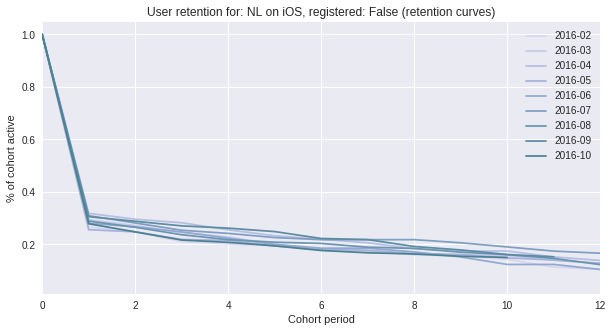

In [400]:
title = 'User retention for: ' + country_value + ' on ' + platform_value +', registered: ' + str(user_registered_value) 

fig, ax = plt.subplots(figsize=(10,5))

seq_col_brew = sns.cubehelix_palette(15, start=2, reverse=False)
sns.set_palette(seq_col_brew)

for i in range(0, len(user_retention.columns)):
    plt.plot(user_retention[user_retention.columns[i]])

plt.title(title + ' (retention curves)')
# plt.imshow(g, cmap='Blues',  interpolation='nearest')
plt.xlabel("Cohort period")
plt.ylabel("% of cohort active")
ax.legend()
plt.xlim(0, 12)
plt.show()

### 3.2. Heatmap

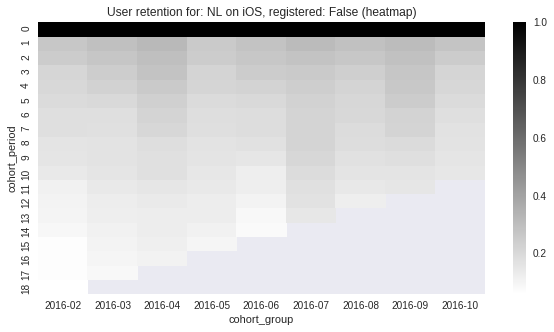

In [223]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(user_retention, cmap="binary", ax=ax)
ax.set_title(title + ' (heatmap)')
plt.show()

## Interactive visualization

In [224]:
def func_cohort_analysis(country, platform, user_registered):
    
    # segmenting users
    segmented_user_events_df = segmenting(all_user_data_df.copy(), country=country, platform=platform, user_registered=user_registered)
    
    # building cohorts
    user_retention = build_cohorts(segmented_user_events_df)
    
    

    # visualization 1 - retention curve
    
    title = 'User retention for: ' + country + ' on ' + platform +', registered: ' + str(user_registered) 
    fig, ax = plt.subplots(figsize=(10,5))
    
    for i in range(0, len(user_retention.columns)):
        plt.plot(user_retention[user_retention.columns[i]])
        
    plt.title(title + ' (retention curves)')
    plt.xlabel("Cohort period")
    plt.ylabel("% of cohort active")
    plt.xlim(0, 12)
    plt.show()
    
    
    
    # visualization 2 - heatmap
    
    fig, ax = plt.subplots(figsize=(10,5))
    sns.heatmap(user_retention, cmap="binary", ax=ax)
    ax.set_title(title + ' (heatmap)')
    plt.show()
    

    
    
interact(func_cohort_analysis, country=country_values , platform=platform_values, user_registered=user_registered_values);